In [1]:
import pandas as pd

# 模拟 2026 美赛 C 题：全球未来医院选址
# 数据包含 5 个备选点 (Site A - Site E) 和 5 个核心指标
data = {
    'City': ['Site A', 'Site B', 'Site C', 'Site D', 'Site E'],
    'Land_Cost': [5000, 8000, 4500, 12000, 3000],      # 地价 (极小值)
    'Pop_Density': [120, 800, 150, 2000, 50],          # 人口密度 (极小值)
    'Hwy_Dist': [4.5, 5.2, 8.0, 1.0, 100.0],           # 距离高速 (中间型, 理想=5) -> 注意 Site E 是巨大离群值
    'Quake_Risk': ['Medium', 'Low', 'Low', 'High', 'Low'], # 地震风险 (文本型) -> 待清洗
    'Bed_Capacity': [500, 1200, 600, 2000, 300]        # 扩容潜力 (极大值)
}

df_raw = pd.DataFrame(data)
df_raw.set_index('City', inplace=True)

# 导出为 Excel
df_raw.to_excel("00_Raw.xlsx")

print("✅ [系统消息]: 原始数据 '00_Raw.xlsx' 生成完毕。")
print("⚠️ [情报]: 侦测到 'Quake_Risk' 为非数值列，侦测到 'Hwy_Dist' 存在极端异常值。")
print("\n数据预览:")
print(df_raw)

✅ [系统消息]: 原始数据 '00_Raw.xlsx' 生成完毕。
⚠️ [情报]: 侦测到 'Quake_Risk' 为非数值列，侦测到 'Hwy_Dist' 存在极端异常值。

数据预览:
        Land_Cost  Pop_Density  Hwy_Dist Quake_Risk  Bed_Capacity
City                                                             
Site A       5000          120       4.5     Medium           500
Site B       8000          800       5.2        Low          1200
Site C       4500          150       8.0        Low           600
Site D      12000         2000       1.0       High          2000
Site E       3000           50     100.0        Low           300


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class TOPSIS_Solver:
    def __init__(self, data: pd.DataFrame):
        """data: 必须是清洗后的纯数值 DataFrame，索引为评价对象"""
        self.raw_data = data.copy()
        self.processed_data = data.copy()
        self.weights = None
        self.results = None

    def preprocess(self, direction_dict: dict, ideal_vals: dict = None):
        """
        direction_dict: {'列名': 'max'/'min'/'mid'}
        ideal_vals: {'列名': 18} (仅当类型为 mid 时需要)
        """
        df = self.processed_data
        for col, direction in direction_dict.items():
            x = df[col].values
            if direction == 'min': # 极小值 -> 极大值
                df[col] = x.max() - x
            elif direction == 'mid': # 中间值 -> 极大值
                if ideal_vals is None or col not in ideal_vals:
                    raise ValueError(f"中间型指标 {col} 必须提供理想值")
                target = ideal_vals[col]
                M = np.max(np.abs(x - target))
                # 防除零处理
                df[col] = 1 - np.abs(x - target) / (M + 1e-6)
        
        # 归一化 (Vector Normalization)
        self.norm_data = df / np.sqrt((df**2).sum())
        # 平移防止熵权法 ln(0) 报错 (使用 Min-Max 辅助计算熵权)
        self.shift_data = (df - df.min()) / (df.max() - df.min()) + 0.001

    def run(self, manual_weights: dict = None):
        """运行计算"""
        # 1. 确定权重 (优先使用人工权重，否则熵权)
        if manual_weights:
            w_series = pd.Series(manual_weights)
            self.weights = w_series / w_series.sum()
        elif self.weights is None:
            # 熵权法计算
            P = self.shift_data.div(self.shift_data.sum(axis=0), axis=1)
            E = -1/np.log(len(P)) * (P * np.log(P)).sum(axis=0)
            d = 1 - E
            self.weights = d / d.sum()
        
        # 2. 计算距离 (TOPSIS 核心)
        Z = self.norm_data * self.weights
        D_plus = np.sqrt(((Z - Z.max())**2).sum(axis=1))
        D_minus = np.sqrt(((Z - Z.min())**2).sum(axis=1))
        
        # 3. 计算得分
        Score = D_minus / (D_plus + D_minus)
        
        # 4. 整合结果
        self.results = self.raw_data.copy()
        self.results['Score'] = Score
        self.results['Rank'] = Score.rank(ascending=False)
        return self.results.sort_values('Rank')

    def plot_sensitivity(self, target_col, change_range=0.2):
        """自动画灵敏度分析图"""
        if self.weights is None: raise ValueError("请先运行 run()")
        base_w = self.weights.copy()
        col_idx = self.raw_data.columns.get_loc(target_col)
        rates = np.linspace(1-change_range, 1+change_range, 20)
        rankings = []
        for r in rates:
            temp_w = base_w.values.copy()
            temp_w[col_idx] *= r 
            temp_w = temp_w / temp_w.sum() # 重新归一化
            # 快速重算
            Z = self.norm_data * temp_w
            Dp = np.sqrt(((Z - Z.max())**2).sum(axis=1))
            Dm = np.sqrt(((Z - Z.min())**2).sum(axis=1))
            S = Dm / (Dp + Dm)
            rankings.append(S.rank(ascending=False).values)
            
        plt.figure(figsize=(8, 5))
        plt.plot(rates, rankings)
        plt.xlabel(f'{target_col} Weight Change Rate')
        plt.ylabel('Rank (Lower is Better)')
        plt.title(f'Sensitivity Analysis: {target_col}')
        plt.gca().invert_yaxis()
        plt.legend(self.raw_data.index, bbox_to_anchor=(1.05, 1))
        plt.grid(True, alpha=0.3)
        plt.show()

In [3]:
# 假设您的 TOPSIS_Solver 类代码已在上面定义

# 1. 读取数据
df = pd.read_excel('00_Raw.xlsx', index_col='City') # 或 read_csv

# 2. 文本映射 (清洗步骤)
mapping_rules = {'Low': 3, 'Medium': 2, 'High': 1}
df['Quake_Risk'] = df['Quake_Risk'].map(mapping_rules)

# 保存清洗版
df.to_excel('01_Clean_v1.xlsx')

# 3. 初始化并设置参数
solver = TOPSIS_Solver(df)
direction = {
    'Land_Cost': 'min',    # 越小越好
    'Pop_Density': 'min',  # 越小越好
    'Bed_Capacity': 'max', # 越大越好
    'Quake_Risk': 'max',   # 越大越好 (3分比1分好)
    'Hwy_Dist': 'mid'      # 中间最好
}
ideal = {'Hwy_Dist': 5}    # 5km 最优

# 4. 预处理 (正向化 + 归一化)
solver.preprocess(direction, ideal)

# 保存正向化矩阵 (用于逻辑检查)
# solver.processed_data 是正向化后、归一化前的数据
solver.processed_data.to_excel('02_Norm_v2.xlsx')

print("处理完成！请检查目录下的 excel 文件。")

处理完成！请检查目录下的 excel 文件。


In [4]:
import pandas as pd
import numpy as np

# --- 1. 定义核心类 ---
class TOPSIS_Solver:
    def __init__(self, data: pd.DataFrame):
        """data: 必须是清洗后的纯数值 DataFrame，索引为评价对象"""
        self.raw_data = data.copy()
        self.processed_data = data.copy()
        self.weights = None
        self.results = None

    def preprocess(self, direction_dict: dict, ideal_vals: dict = None):
        """
        direction_dict: {'列名': 'max'/'min'/'mid'}
        ideal_vals: {'列名': 18} (仅当类型为 mid 时需要)
        """
        df = self.processed_data
        for col, direction in direction_dict.items():
            x = df[col].values
            if direction == 'min': # 极小值 -> 极大值 (x_max - x)
                df[col] = x.max() - x
            elif direction == 'mid': # 中间值 -> 极大值
                if ideal_vals is None or col not in ideal_vals:
                    raise ValueError(f"中间型指标 {col} 必须提供理想值")
                target = ideal_vals[col]
                M = np.max(np.abs(x - target))
                # 防除零处理
                df[col] = 1 - np.abs(x - target) / (M + 1e-6)
        
        # 归一化 (Vector Normalization)
        self.norm_data = df / np.sqrt((df**2).sum())
        # 平移防止熵权法 ln(0) 报错 (使用 Min-Max 辅助计算熵权)
        self.shift_data = (df - df.min()) / (df.max() - df.min()) + 0.001

    def run(self, manual_weights: dict = None):
        """运行计算"""
        # 1. 确定权重 (优先使用人工权重，否则熵权)
        if manual_weights:
            w_series = pd.Series(manual_weights)
            self.weights = w_series / w_series.sum()
        elif self.weights is None:
            # 熵权法计算
            P = self.shift_data.div(self.shift_data.sum(axis=0), axis=1)
            # 防止 P 中有 0 导致 log 报错，虽然 shift_data 已经 +0.001，双重保险
            P = P.fillna(0)
            E = -1/np.log(len(P)) * (P * np.log(P)).sum(axis=0)
            d = 1 - E
            self.weights = d / d.sum()
        
        # 2. 计算距离 (TOPSIS 核心)
        Z = self.norm_data * self.weights
        D_plus = np.sqrt(((Z - Z.max())**2).sum(axis=1))
        D_minus = np.sqrt(((Z - Z.min())**2).sum(axis=1))
        
        # 3. 计算得分
        Score = D_minus / (D_plus + D_minus)
        
        # 4. 整合结果
        self.results = self.raw_data.copy()
        self.results['Score'] = Score
        self.results['Rank'] = Score.rank(ascending=False)
        return self.results.sort_values('Rank')

# --- 2. 主执行逻辑 ---
if __name__ == "__main__":
    # ================= 步骤 1: 读取与清洗 =================
    print(">>> 正在读取 00_Raw.xlsx ...")
    try:
        # 如果您的文件是 xlsx
        df_raw = pd.read_excel('00_Raw.xlsx', index_col='City')
    except:
        # 备用：如果是 csv
        df_raw = pd.read_csv('00_Raw.xlsx', index_col='City')

    # 文本映射处理
    mapping = {'Low': 3, 'Medium': 2, 'High': 1}
    df_clean = df_raw.copy()
    if df_clean['Quake_Risk'].dtype == 'O': # 只有当它是文本时才映射
        df_clean['Quake_Risk'] = df_clean['Quake_Risk'].map(mapping)
    
    # 保存清洗版
    df_clean.to_excel('01_Clean_v1.xlsx')
    print(">>> [成功] 01_Clean_v1.xlsx 已保存。")

    # ================= 步骤 2: 初始化与预处理 =================
    solver = TOPSIS_Solver(df_clean)
    
    # 定义指标方向
    direction_dict = {
        'Land_Cost': 'min',    # 越小越好
        'Pop_Density': 'min',  # 越小越好
        'Bed_Capacity': 'max', # 越大越好
        'Quake_Risk': 'max',   # 映射后：3分>1分，越大越好
        'Hwy_Dist': 'mid'      # 中间型
    }
    ideal_vals = {'Hwy_Dist': 5} # 理想距离 5km

    # 执行预处理
    solver.preprocess(direction_dict, ideal_vals)
    
    # 保存正向化矩阵 (用于逻辑核查)
    solver.processed_data.to_excel('02_Norm_v2.xlsx')
    print(">>> [成功] 02_Norm_v2.xlsx (正向化矩阵) 已保存。")

    # ================= 步骤 3: 逻辑核查 (在终端打印) =================
    print("\n--- 逻辑核查 ---")
    
    # 检查 1: 高速距离是否正向化正确 (5km 附近应该接近 1)
    target_dist = 5
    city_near_5 = df_raw.iloc[(df_raw['Hwy_Dist'] - target_dist).abs().argsort()[:1]]
    city_name = city_near_5.index[0]
    raw_val = city_near_5['Hwy_Dist'].values[0]
    norm_val = solver.processed_data.loc[city_name, 'Hwy_Dist']
    
    print(f"[Check 1] 距离高速最近似 5km 的城市: {city_name} (原值: {raw_val}km)")
    print(f"          正向化后得分 (应接近 1.0): {norm_val:.4f}")
    if norm_val > 0.9: print("          -> 校验通过 ✅")
    else: print("          -> 校验警告 ⚠️")

    # 检查 2: 地价 (极小值)
    city_expensive = df_raw[df_raw['Land_Cost'] == df_raw['Land_Cost'].max()]
    city_name_exp = city_expensive.index[0]
    norm_val_exp = solver.processed_data.loc[city_name_exp, 'Land_Cost']
    
    print(f"[Check 2] 地价最贵的城市: {city_name_exp} (原值: {city_expensive['Land_Cost'].values[0]})")
    print(f"          正向化后得分 (应为 0): {norm_val_exp:.4f}")
    if norm_val_exp < 0.001: print("          -> 校验通过 ✅")
    else: print("          -> 校验警告 ⚠️")

    # ================= 步骤 4: 运行计算与保存结果 =================
    print("\n>>> 正在运行熵权法计算 ...")
    final_results = solver.run() # 默认使用熵权法
    
    # 保存结果
    final_results.to_excel('03_Draft_v3.xlsx')
    
    print("\n--- 熵权 (Weights) ---")
    print(solver.weights.sort_values(ascending=False))
    
    print("\n--- 最终排名 (Top 5) ---")
    print(final_results[['Score', 'Rank']])
    print("\n>>> [成功] 03_Draft_v3.xlsx 已保存。流程结束。")

>>> 正在读取 00_Raw.xlsx ...
>>> [成功] 01_Clean_v1.xlsx 已保存。
>>> [成功] 02_Norm_v2.xlsx (正向化矩阵) 已保存。

--- 逻辑核查 ---
[Check 1] 距离高速最近似 5km 的城市: Site B (原值: 5.2km)
          正向化后得分 (应接近 1.0): 0.9979
          -> 校验通过 ✅
[Check 2] 地价最贵的城市: Site D (原值: 12000)
          正向化后得分 (应为 0): 0.0000
          -> 校验通过 ✅

>>> 正在运行熵权法计算 ...

--- 熵权 (Weights) ---
Bed_Capacity    0.345198
Land_Cost       0.173876
Quake_Risk      0.171940
Pop_Density     0.159977
Hwy_Dist        0.149009
dtype: float64

--- 最终排名 (Top 5) ---
           Score  Rank
City                  
Site D  0.616333   1.0
Site B  0.570479   2.0
Site C  0.453541   3.0
Site A  0.411833   4.0
Site E  0.382754   5.0

>>> [成功] 03_Draft_v3.xlsx 已保存。流程结束。


最终排名结果：
           Score  Rank
City                  
Site B  0.587768   1.0
Site D  0.548220   2.0
Site C  0.498952   3.0
Site E  0.451201   4.0
Site A  0.415988   5.0
灵敏度分析图已保存为 sensitivity_analysis.png


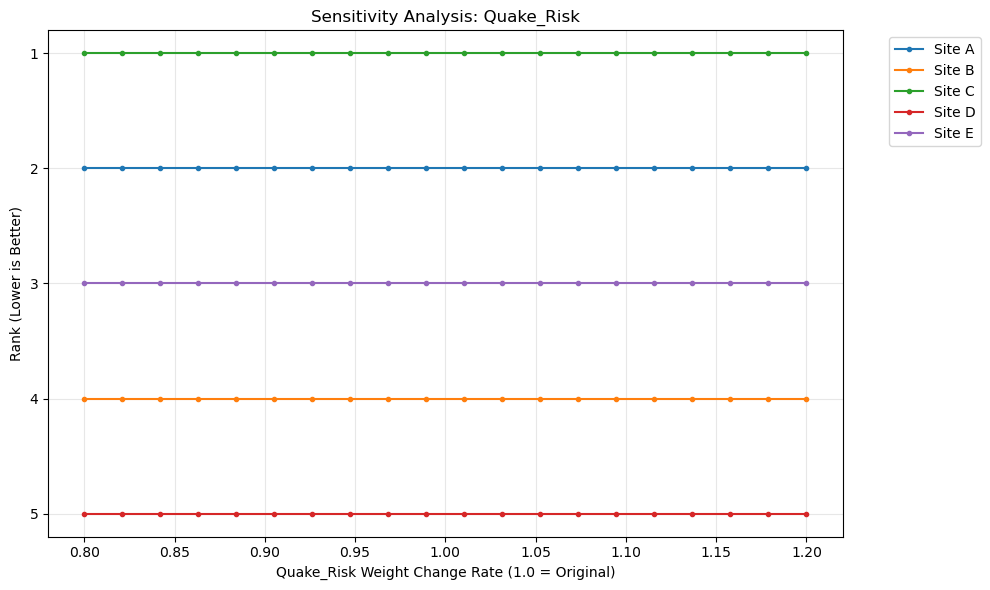

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 类定义 ---
class TOPSIS_Solver:
    def __init__(self, data: pd.DataFrame):
        self.raw_data = data.copy()
        self.processed_data = data.copy()
        self.weights = None
        self.results = None

    def preprocess(self, direction_dict: dict, ideal_vals: dict = None):
        df = self.processed_data
        for col, direction in direction_dict.items():
            x = df[col].values
            if direction == 'min': 
                df[col] = x.max() - x
            elif direction == 'mid': 
                if ideal_vals is None or col not in ideal_vals:
                    raise ValueError(f"中间型指标 {col} 必须提供理想值")
                target = ideal_vals[col]
                M = np.max(np.abs(x - target))
                df[col] = 1 - np.abs(x - target) / (M + 1e-6)
        
        # 归一化
        self.norm_data = df / np.sqrt((df**2).sum())

    def run(self, manual_weights: dict = None):
        # 权重归一化
        if manual_weights:
            w_series = pd.Series(manual_weights)
            self.weights = w_series / w_series.sum()
        else:
            raise ValueError("本次运行需要提供 manual_weights")
        
        # TOPSIS 距离计算
        Z = self.norm_data * self.weights
        D_plus = np.sqrt(((Z - Z.max())**2).sum(axis=1))
        D_minus = np.sqrt(((Z - Z.min())**2).sum(axis=1))
        Score = D_minus / (D_plus + D_minus)
        
        self.results = self.raw_data.copy()
        self.results['Score'] = Score
        self.results['Rank'] = Score.rank(ascending=False)
        return self.results.sort_values('Rank')

    def plot_sensitivity(self, target_col, change_range=0.2):
        """灵敏度分析绘图"""
        if self.weights is None: raise ValueError("请先运行 run()")
        
        base_w = self.weights.copy()
        col_idx = self.raw_data.columns.get_loc(target_col)
        rates = np.linspace(1-change_range, 1+change_range, 20)
        rankings = []
        
        # 模拟权重变化
        for r in rates:
            temp_w = base_w.values.copy()
            temp_w[col_idx] *= r 
            temp_w = temp_w / temp_w.sum() # 重新归一化确保和为1
            
            # 快速重算排名
            Z = self.norm_data * temp_w
            Dp = np.sqrt(((Z - Z.max())**2).sum(axis=1))
            Dm = np.sqrt(((Z - Z.min())**2).sum(axis=1))
            S = Dm / (Dp + Dm)
            rankings.append(S.rank(ascending=False).values)
            
        # 绘图
        plt.figure(figsize=(10, 6))
        plt.plot(rates, rankings, marker='o', markersize=3)
        plt.xlabel(f'{target_col} Weight Change Rate (1.0 = Original)')
        plt.ylabel('Rank (Lower is Better)')
        plt.title(f'Sensitivity Analysis: {target_col}')
        plt.gca().invert_yaxis() # 排名越小越好，反转Y轴
        plt.yticks(range(1, len(self.raw_data)+1))
        plt.legend(self.raw_data.index, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('sensitivity_analysis.png') # 保存图片
        print("灵敏度分析图已保存为 sensitivity_analysis.png")
        plt.show()

# --- 2. 主程序 ---
if __name__ == "__main__":
    # 读取数据
    df = pd.read_excel('00_Raw.xlsx', index_col='City') # 或 csv
    
    # 清洗：映射文本
    df['Quake_Risk'] = df['Quake_Risk'].map({'Low': 3, 'Medium': 2, 'High': 1})
    
    # 初始化
    solver = TOPSIS_Solver(df)
    solver.preprocess(
        direction_dict={
            'Land_Cost': 'min', 'Pop_Density': 'min', 
            'Bed_Capacity': 'max', 'Quake_Risk': 'max', 
            'Hwy_Dist': 'mid'
        },
        ideal_vals={'Hwy_Dist': 5}
    )
    
    # 设定人工权重
    my_weights = {
        'Quake_Risk': 0.3, 
        'Bed_Capacity': 0.3, 
        'Land_Cost': 0.2, 
        'Hwy_Dist': 0.1, 
        'Pop_Density': 0.1
    }
    
    # 运行与保存
    final_df = solver.run(manual_weights=my_weights)
    final_df.to_excel('04_Final_Submission.xlsx')
    
    print("最终排名结果：")
    print(final_df[['Score', 'Rank']])
    
    # 灵敏度分析
    solver.plot_sensitivity('Quake_Risk')
